In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# wrangle
import wrangle as w

# modeling and evaluate
import modeling_evaluate as me
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# Plt defaults
# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(14, 8))
plt.rc('font', size=16)

In [2]:
mental_health_df, population_df, rates_df, depressive_rates_df = w.separate_data()

mental_health_df = w.clean_mental_health_data(mental_health_df)
depressive_rates_df = w.clean_depressive_rates_data(depressive_rates_df)
population_df = w.clean_population_data(population_df)
rates_df = w.clean_rates_data(rates_df)

yearly_disorders, yearly_prevalence_sex, yearly_depressive_rates, yearly_suicide_rates = w.yearly_aggregation()

df = w.merge_yearly_aggregation()

train_yearly, test_yearly = w.split_yearly_data()

train, validate, test = w.split_data(df)

X_cols = ['prevelance_depressive_disorder', 'anxiety_disorders']

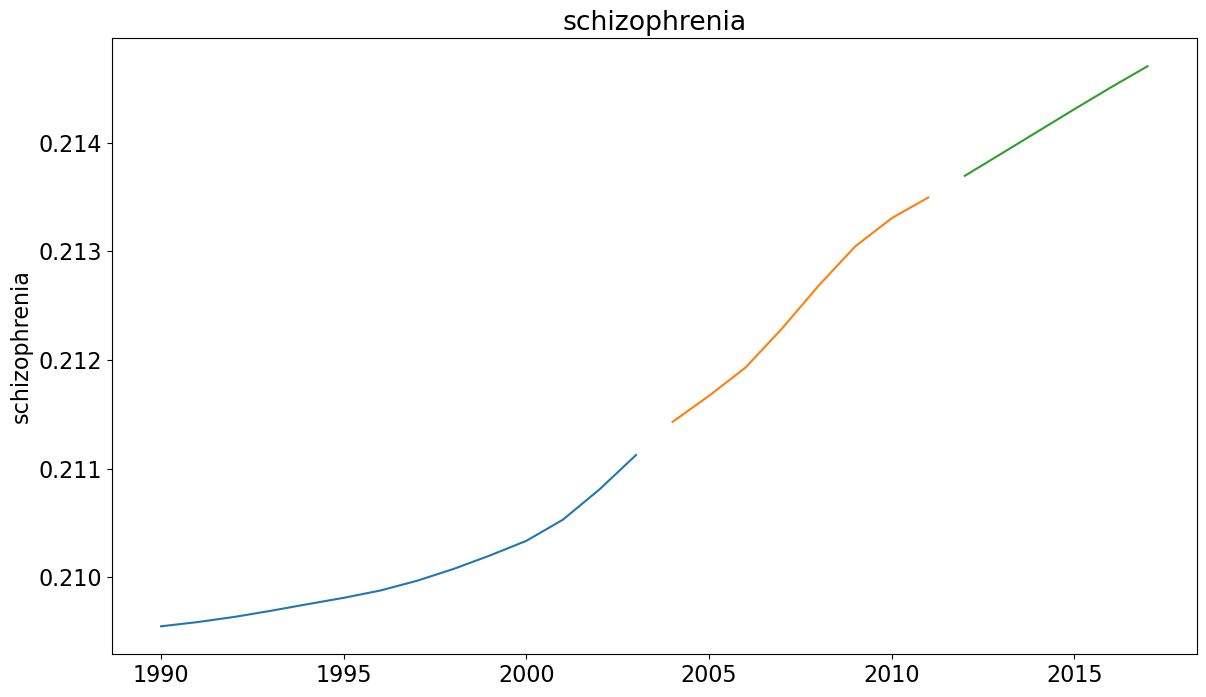

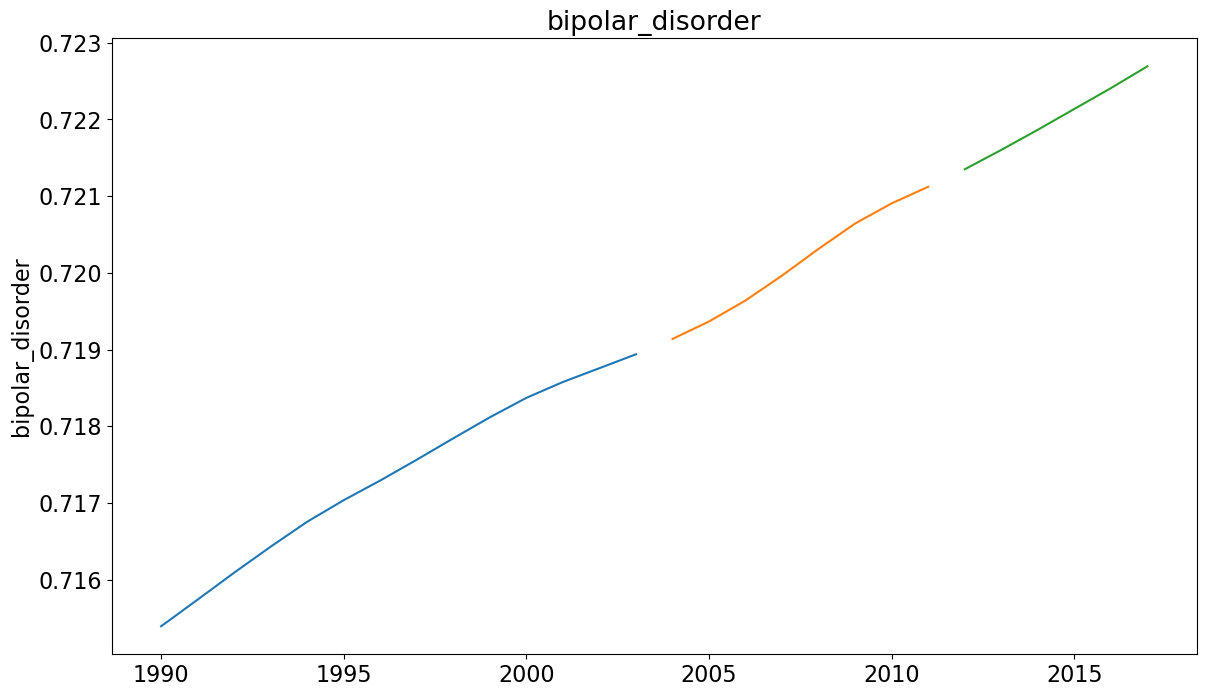

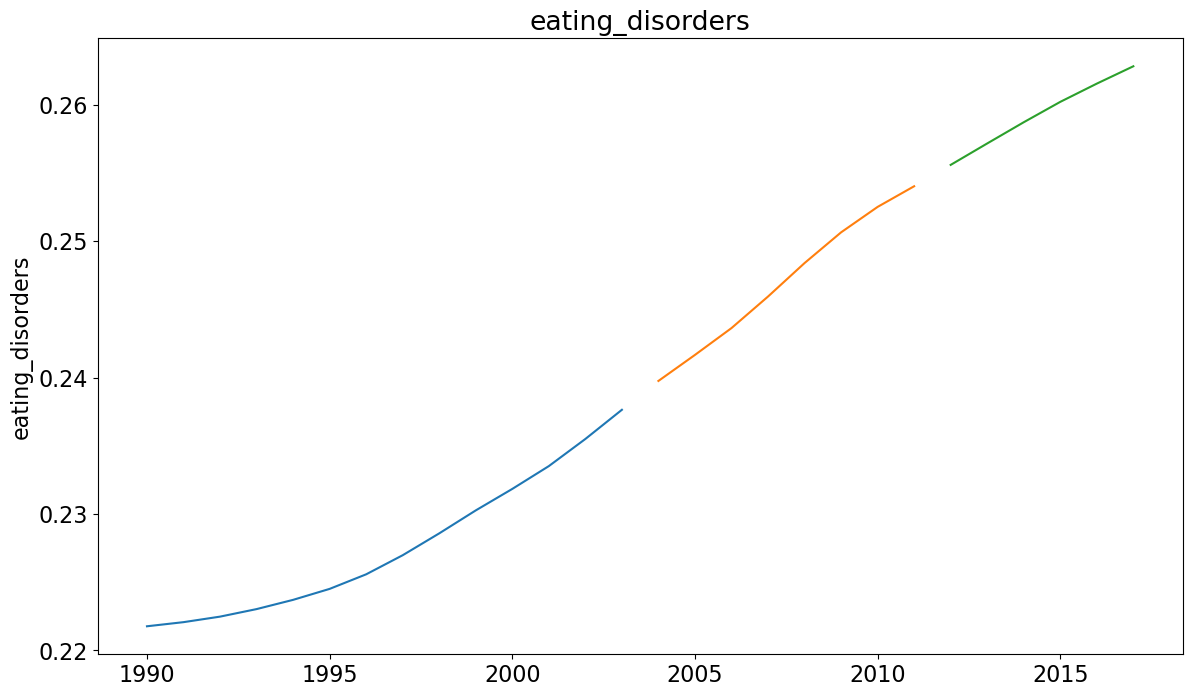

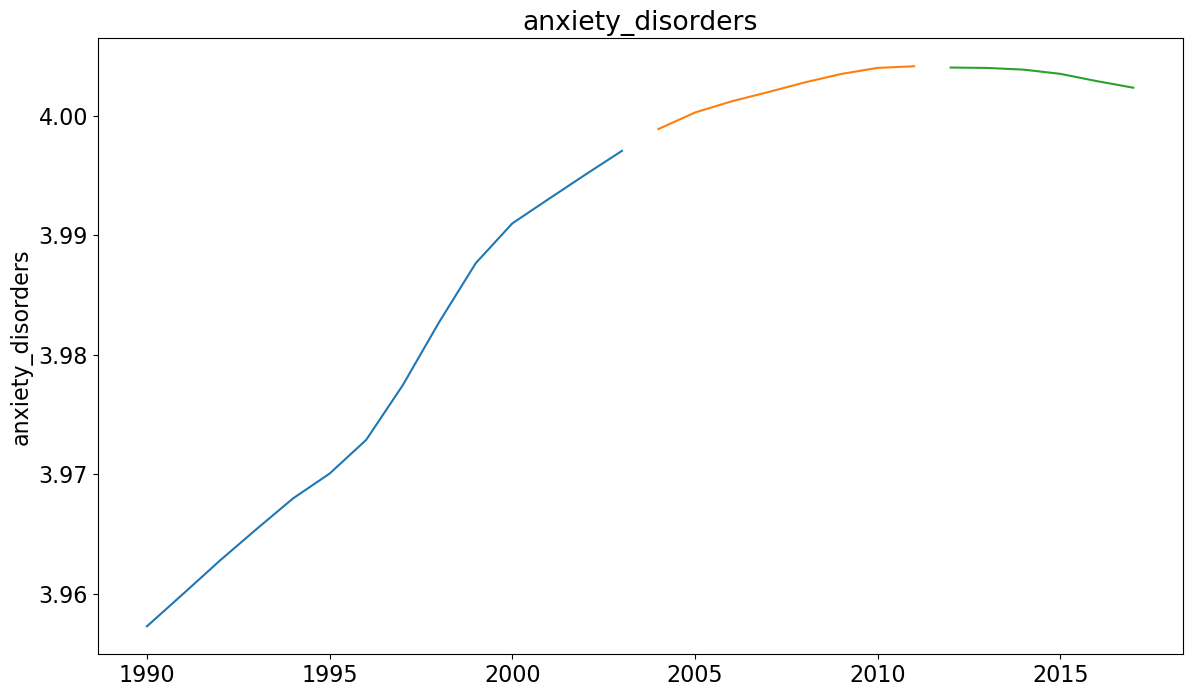

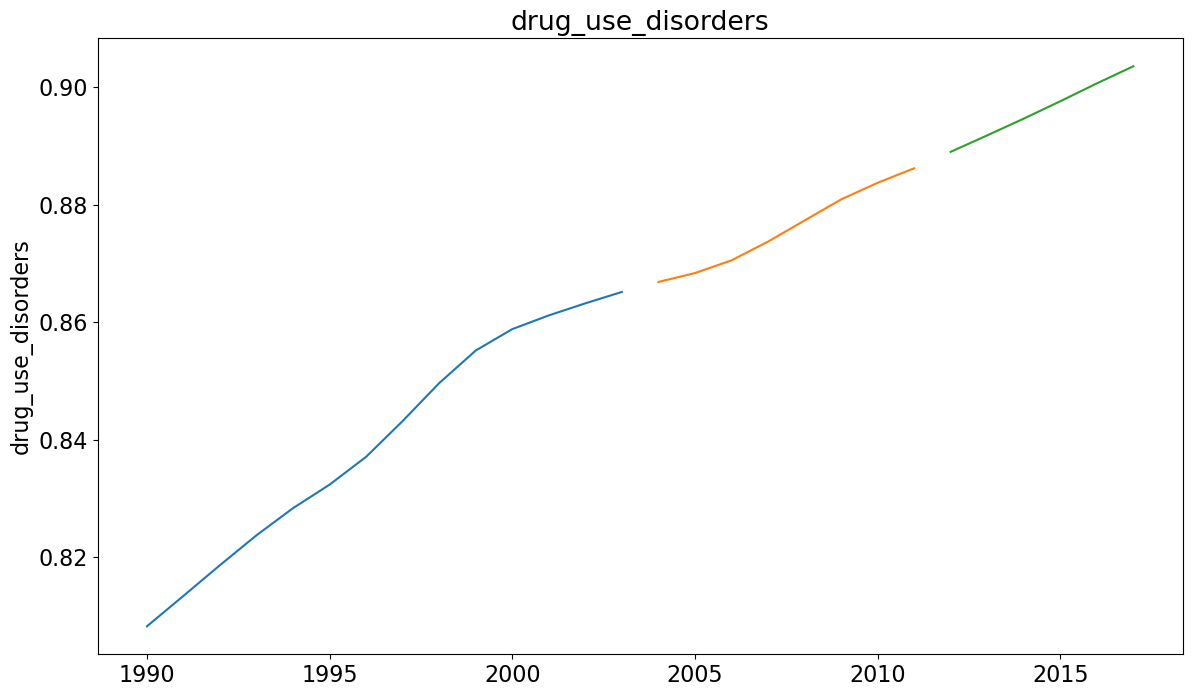

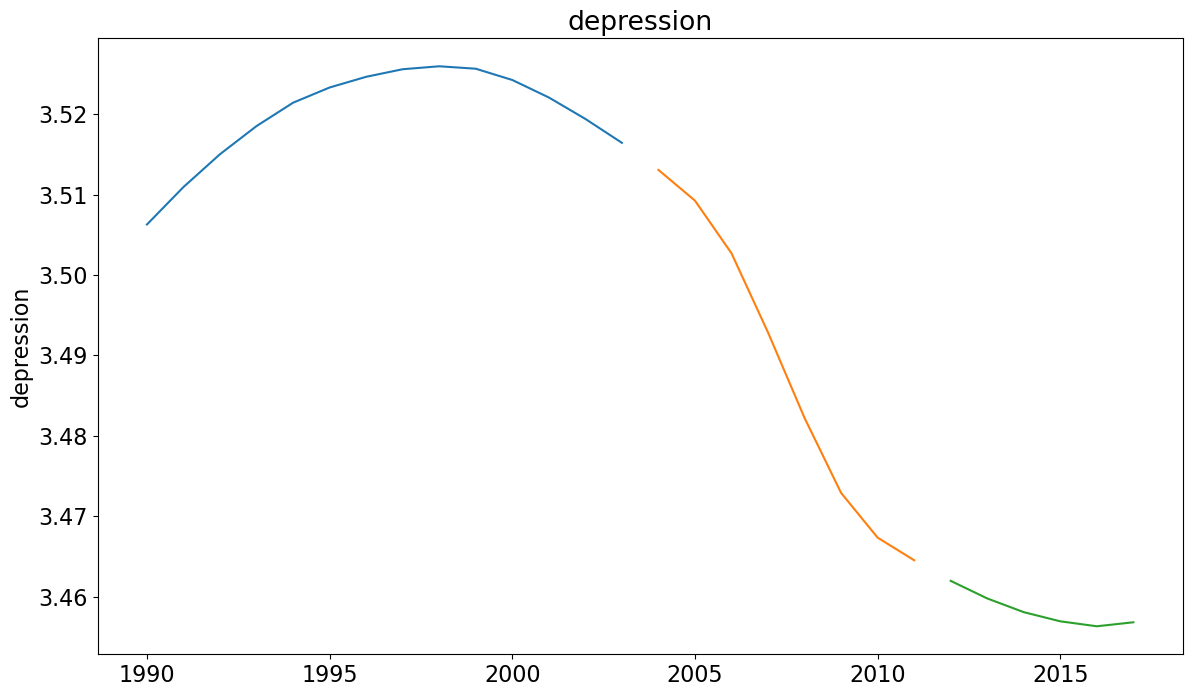

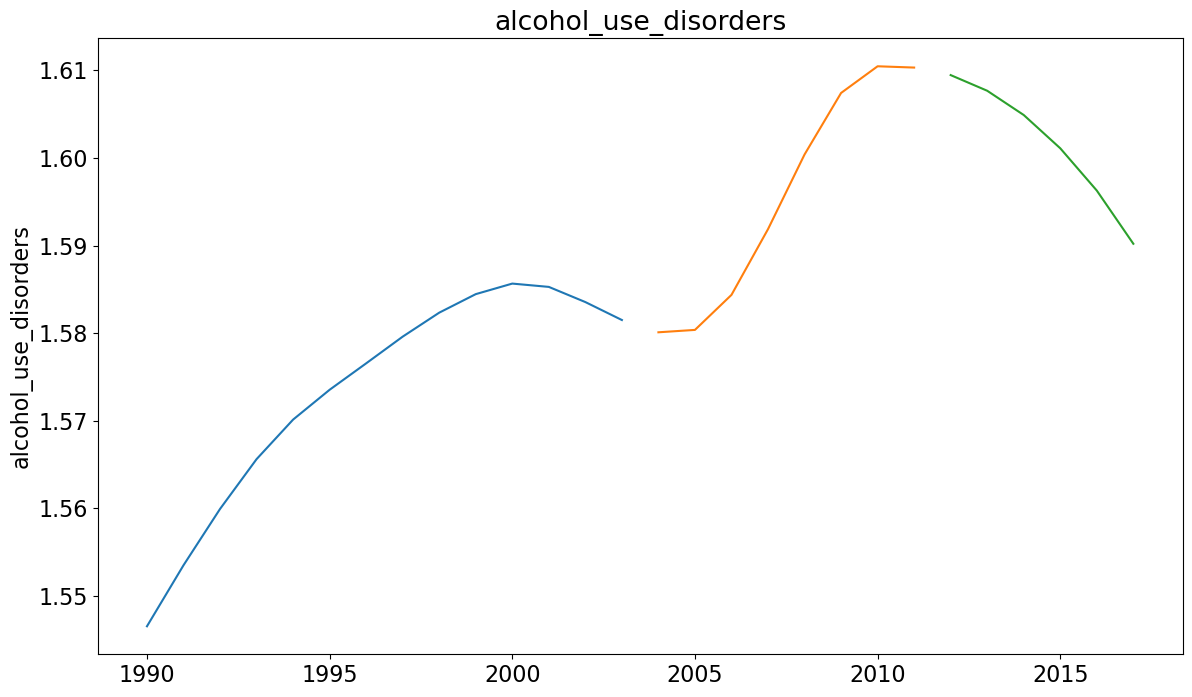

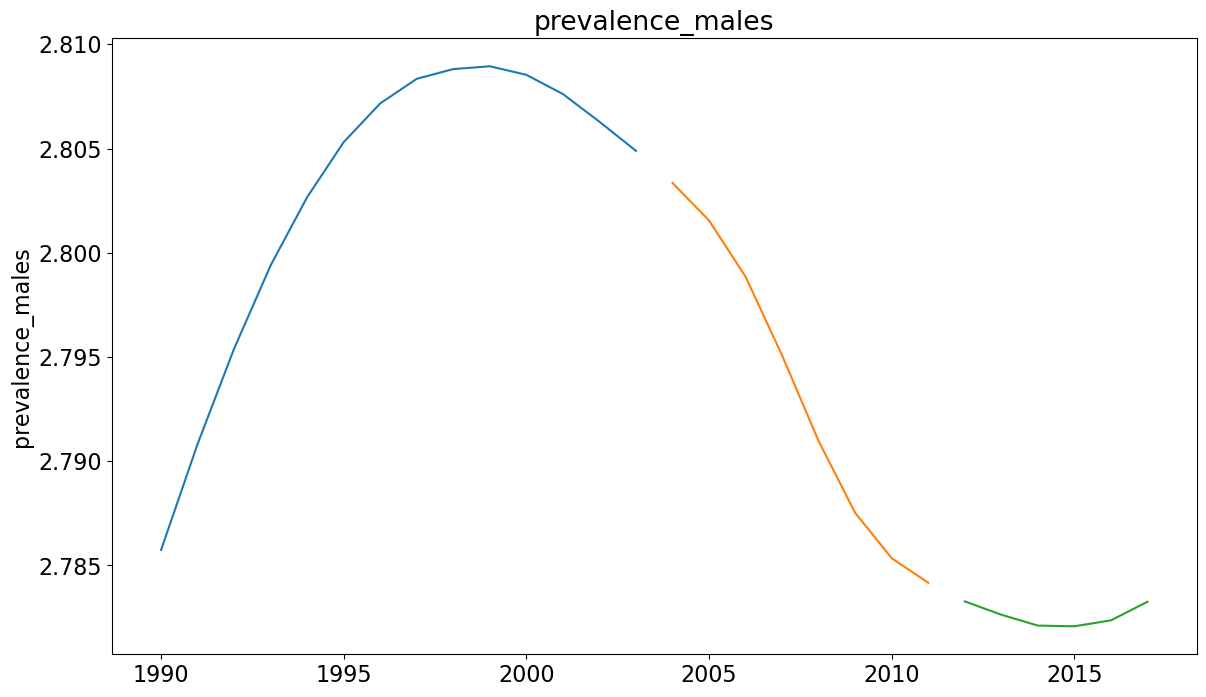

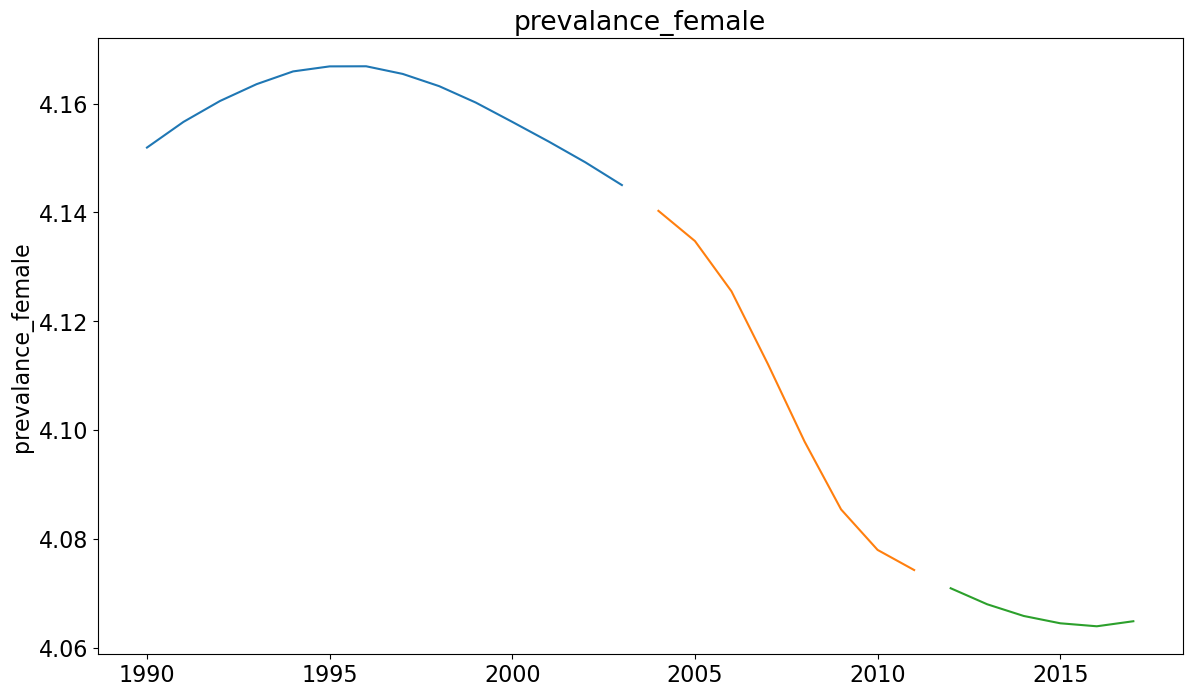

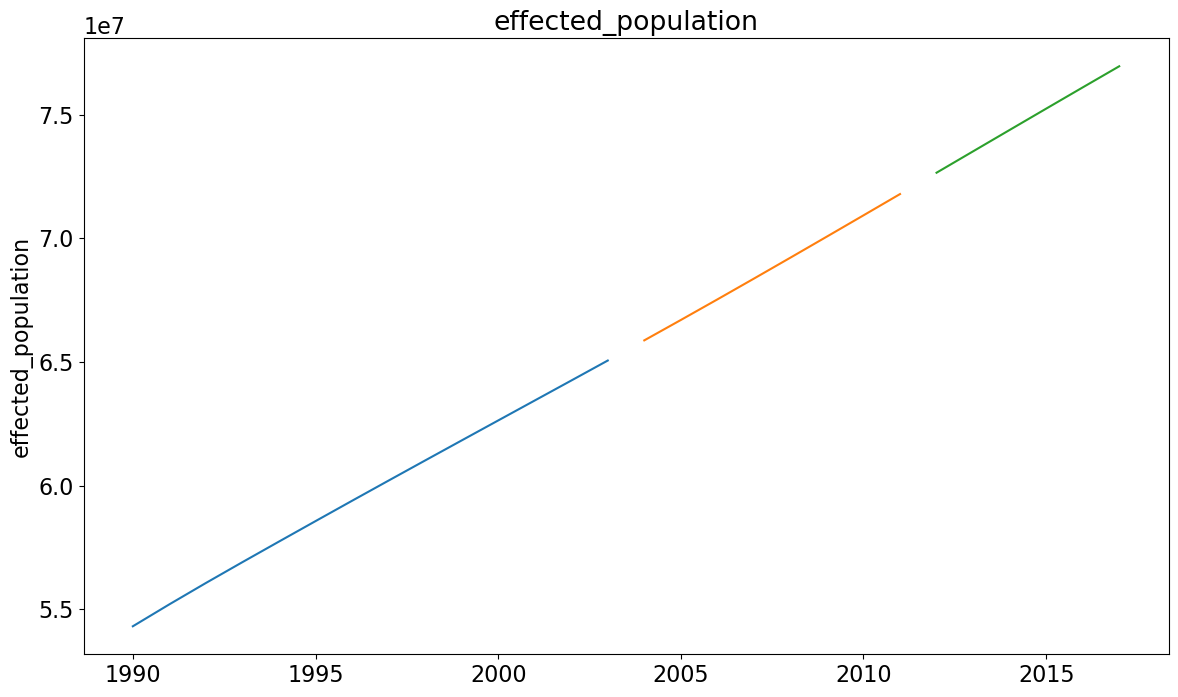

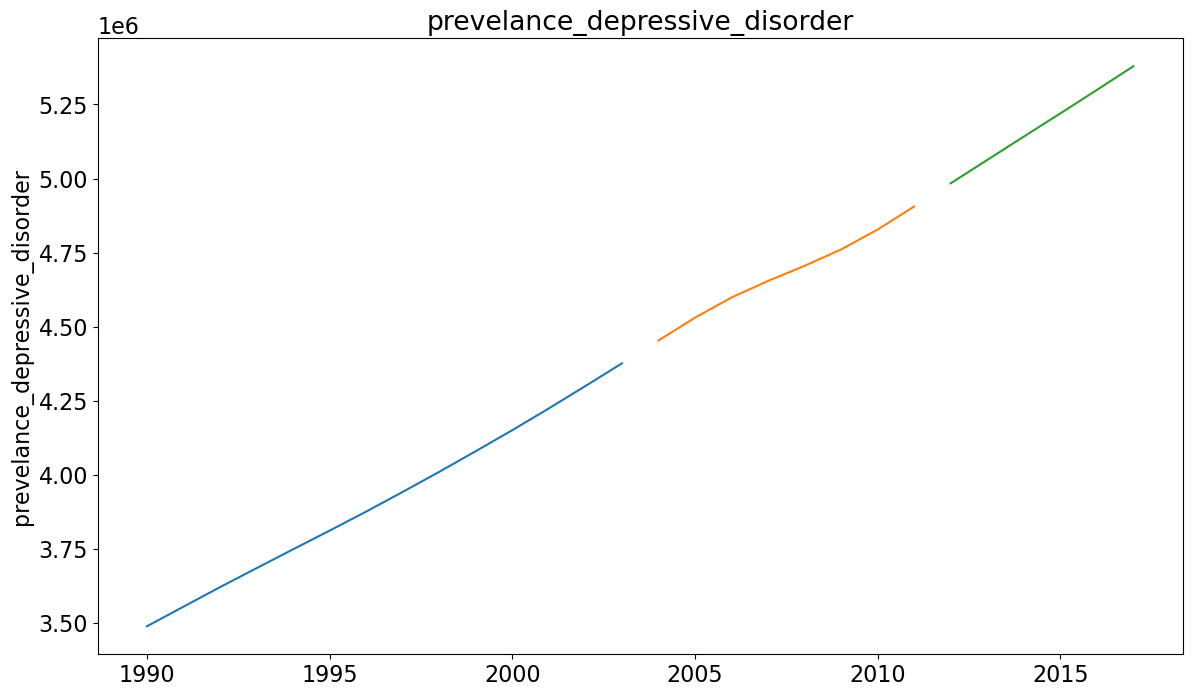

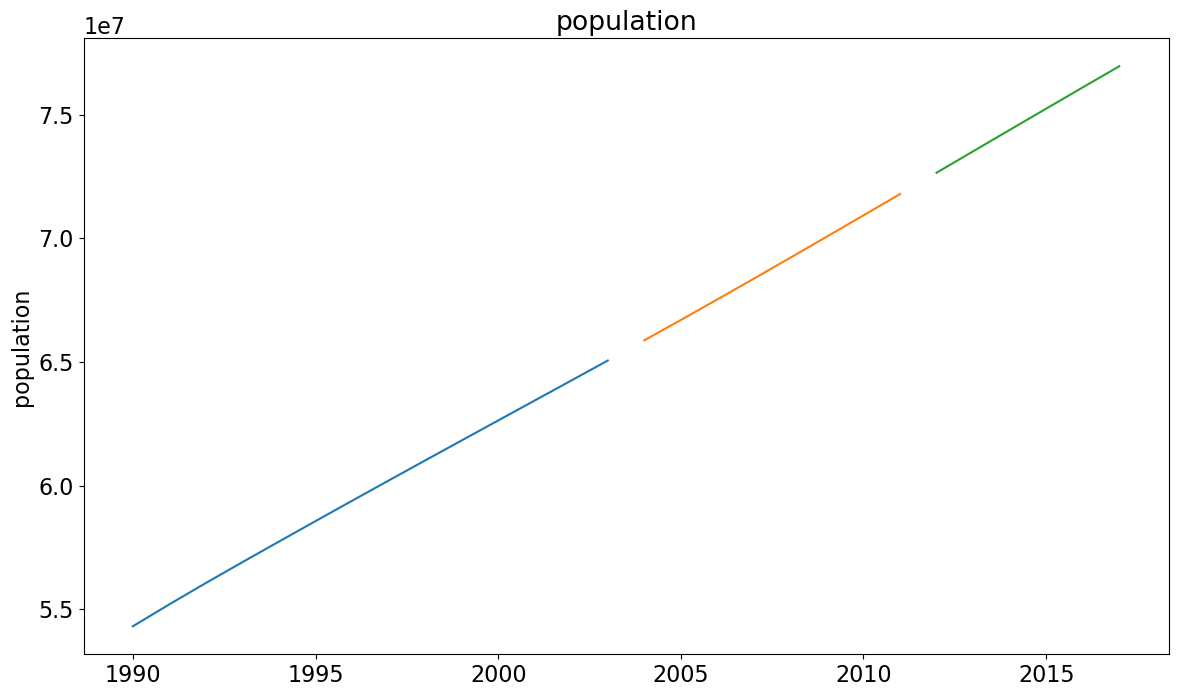

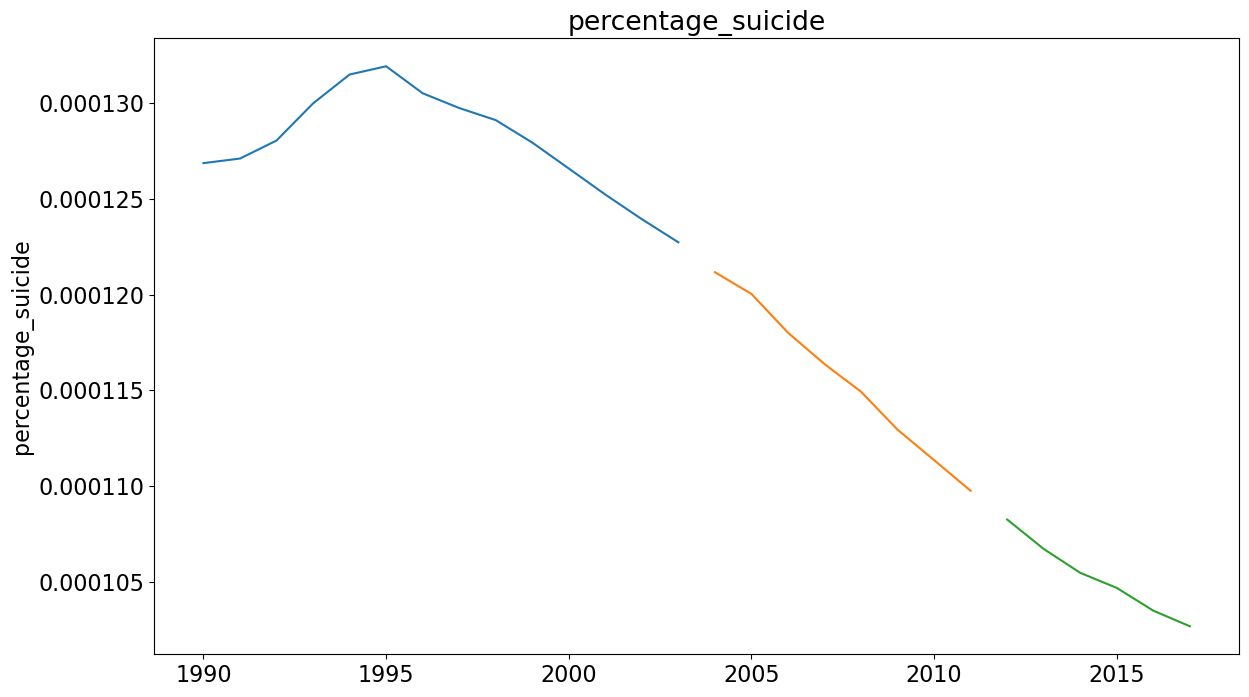

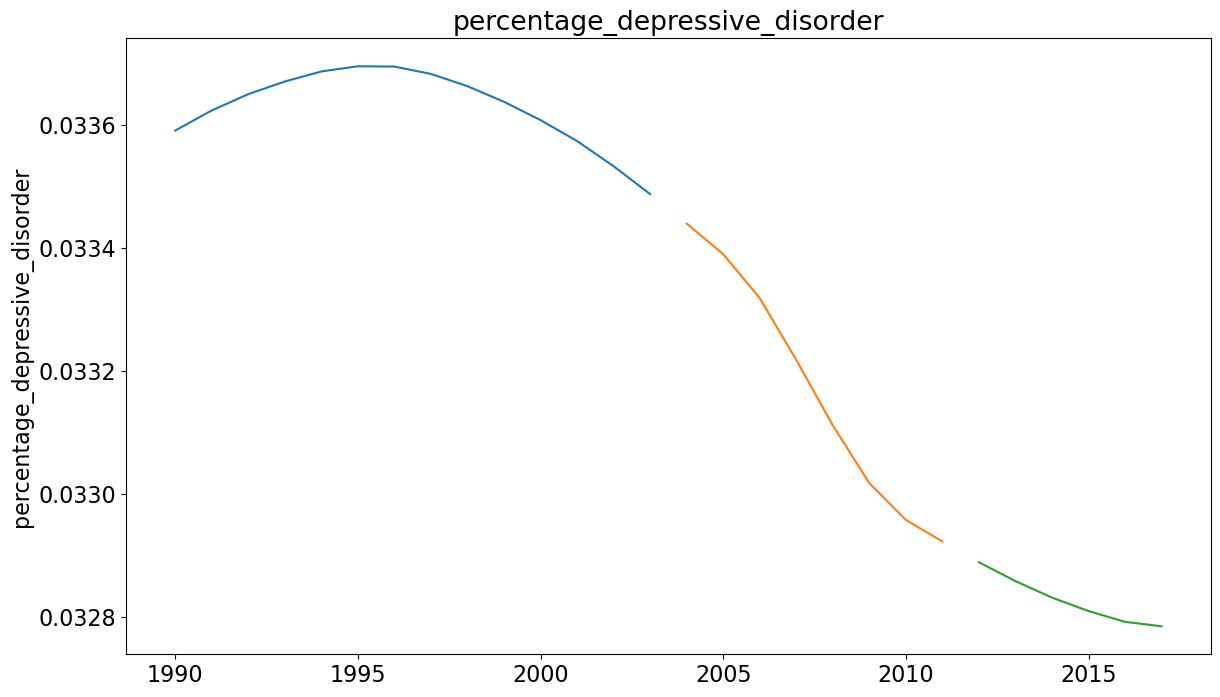

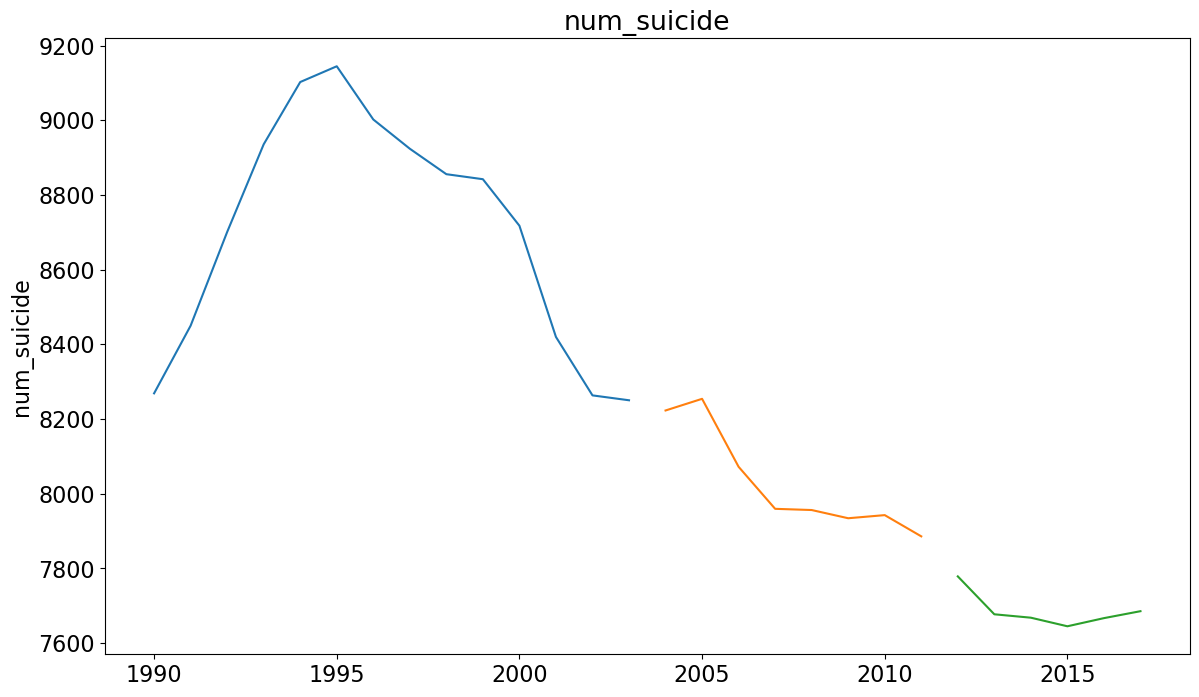

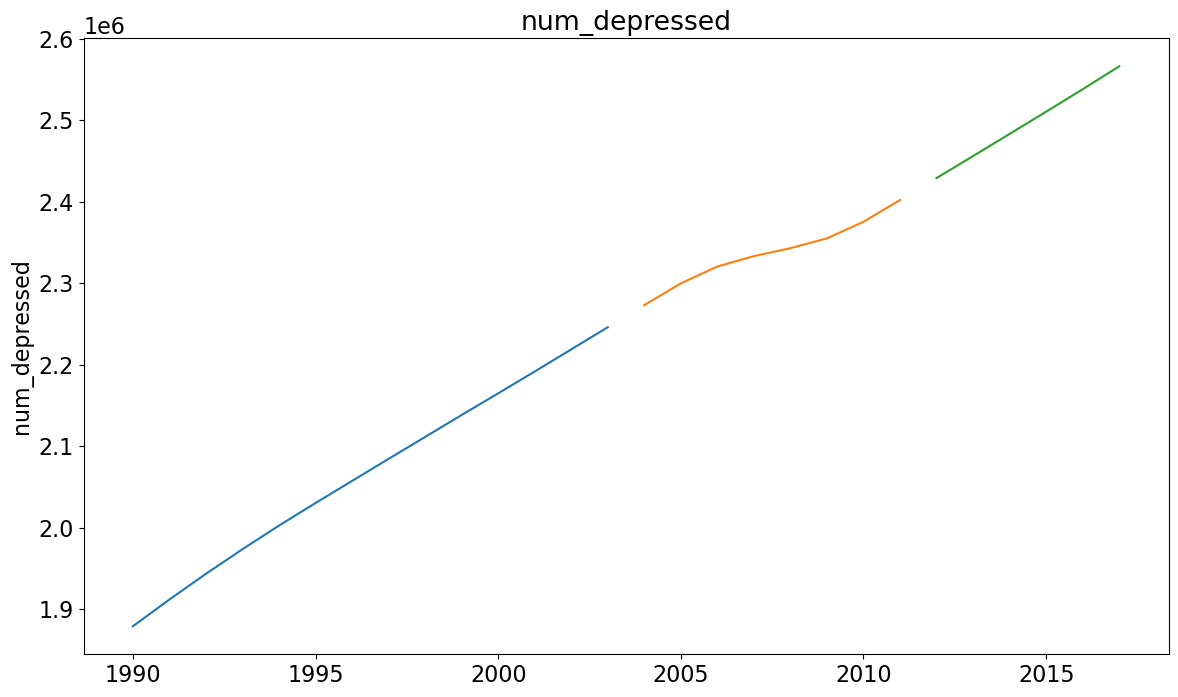

In [3]:
for col in train.columns:
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

The targets for modeling will be 'prevelance_depressive_disorder', which is the number of people in 1 year, and 'anxiety_disorders'.

### Forecasting

#### Last Observed Value

In [4]:
last_depressive_rate = train.iloc[-1]['prevelance_depressive_disorder']

In [5]:
last_anxiety_rate = train.iloc[-1]['anxiety_disorders']

In [6]:
yhat_df = pd.DataFrame(

    {'prevelance_depressive_disorder': [last_depressive_rate],
     'anxiety_disorders': [last_anxiety_rate]
    }, index=validate.index

)
yhat_df

,prevelance_depressive_disorder,anxiety_disorders
year,,
2004,4.376706e+06,3.997061
2005,4.376706e+06,3.997061
2006,4.376706e+06,3.997061
2007,4.376706e+06,3.997061
2008,4.376706e+06,3.997061
2009,4.376706e+06,3.997061
2010,4.376706e+06,3.997061
2011,4.376706e+06,3.997061


In [7]:
X_cols

['prevelance_depressive_disorder', 'anxiety_disorders']

prevelance_depressive_disorder -- RMSE: 334699


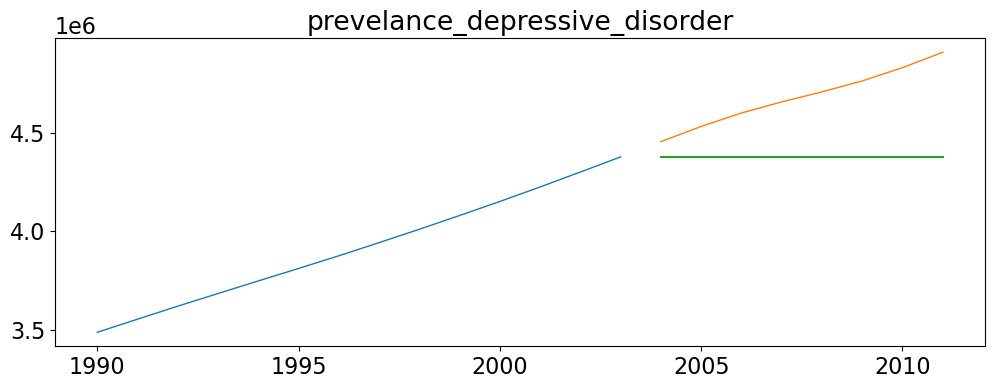

anxiety_disorders -- RMSE: 0


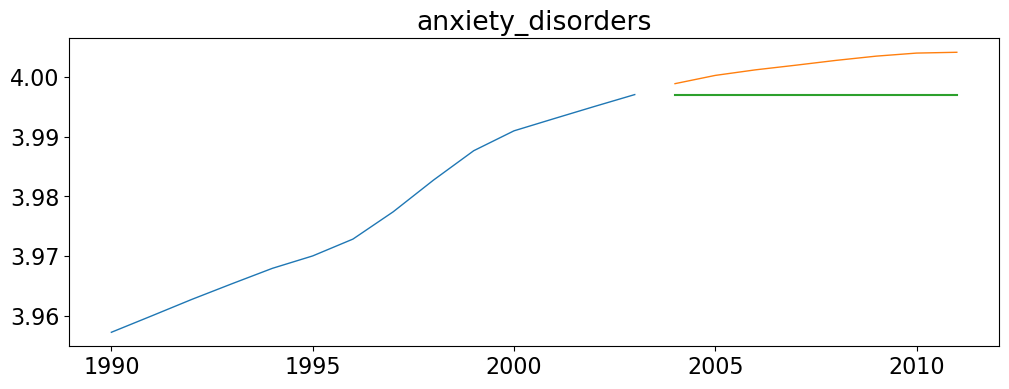

In [8]:
for col in train[X_cols].columns:
    me.plot_and_eval(yhat_df, target_var=col)

In [9]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [10]:
for col in train[X_cols].columns:
    d = me.append_eval_df(yhat_df, model_type = 'last_observed_value', target_var = col)
    eval_df = eval_df.append(d, ignore_index=True)

#### Simple Average

In [11]:
avg_depression = train['prevelance_depressive_disorder'].mean()
avg_anxiety = train['anxiety_disorders'].mean()

In [12]:
yhat_df

,prevelance_depressive_disorder,anxiety_disorders
year,,
2004,4.376706e+06,3.997061
2005,4.376706e+06,3.997061
2006,4.376706e+06,3.997061
2007,4.376706e+06,3.997061
2008,4.376706e+06,3.997061
2009,4.376706e+06,3.997061
2010,4.376706e+06,3.997061
2011,4.376706e+06,3.997061


In [13]:
def make_predictions(depression=None, anxiety=None):
    yhat_df = pd.DataFrame({'prevelance_depressive_disorder': [depression],
                           'anxiety_disorders': [anxiety]},
                          index=validate.index)
    return yhat_df

In [14]:
yhat_df = make_predictions(avg_depression, avg_anxiety)

prevelance_depressive_disorder -- RMSE: 772934


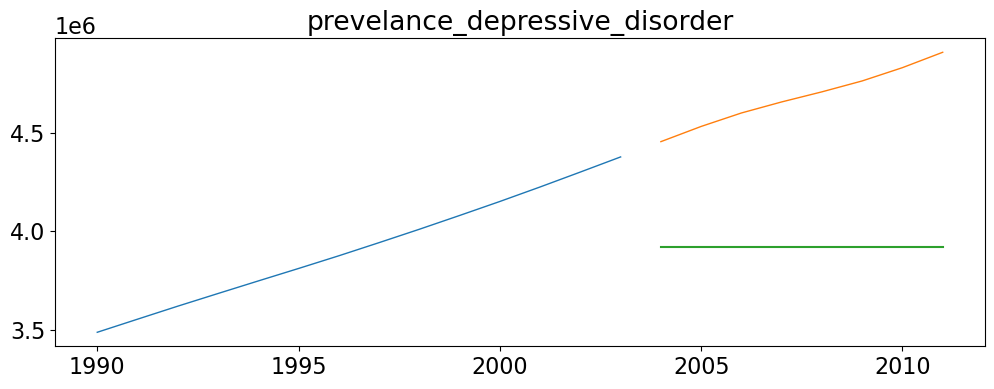

anxiety_disorders -- RMSE: 0


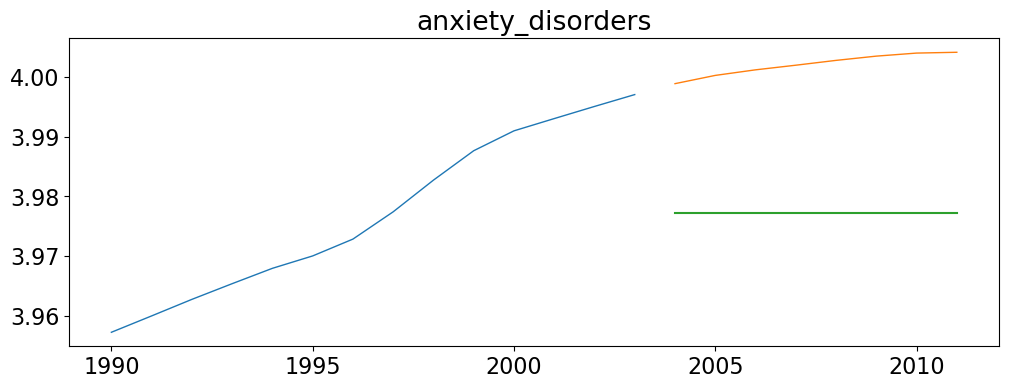

In [15]:
for col in train[X_cols].columns:
    me.plot_and_eval(yhat_df, target_var=col)

In [16]:
for col in train[X_cols].columns:
    d = me.append_eval_df(yhat_df, model_type = 'simple_average', target_var = col)
    eval_df = eval_df.append(d, ignore_index=True)

#### Moving Average

In [17]:
period = 1 

rolling_depression = train['prevelance_depressive_disorder'].rolling(period).mean()
rolling_anxiety = train['anxiety_disorders'].rolling(period).mean()
rolling_anxiety = rolling_anxiety.tolist()[-1]
rolling_depression= rolling_depression.tolist()[-1]

In [18]:
yhat_df = make_predictions(rolling_depression, rolling_anxiety)

prevelance_depressive_disorder -- RMSE: 334699


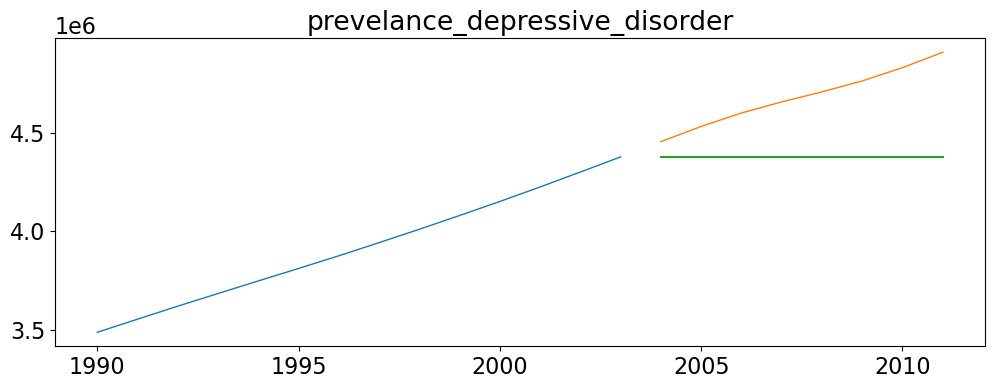

anxiety_disorders -- RMSE: 0


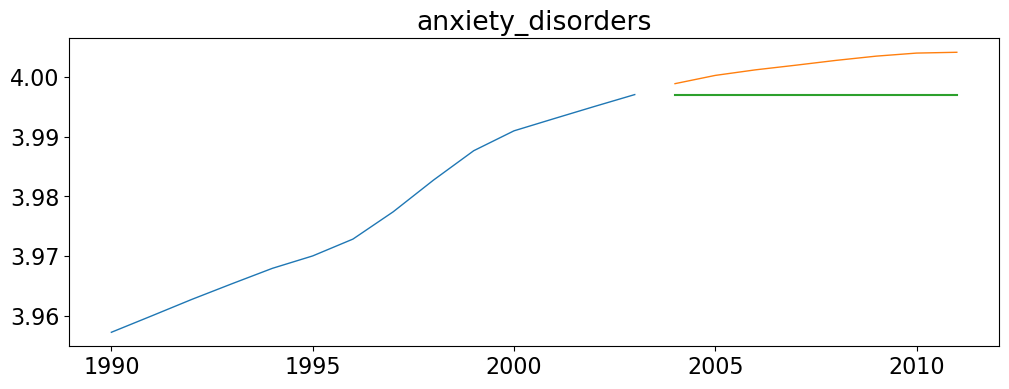

In [19]:
for col in train[X_cols].columns:
    me.plot_and_eval(yhat_df, target_var=col)

In [20]:
for col in train[X_cols].columns:
    d = me.append_eval_df(yhat_df, model_type = 'moving_average', target_var = col)
    eval_df = eval_df.append(d, ignore_index=True)

#### Holt's Linear Trend

In [21]:
# doing this in a loop for each column
for col in train[X_cols].columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = yhat_items

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Predi

In [22]:
yhat_df

,prevelance_depressive_disorder,anxiety_disorders
year,,
2004,1.122992e+07,4.1942
2005,1.122992e+07,4.1942
2006,1.122992e+07,4.1942
2007,1.122992e+07,4.1942
2008,1.122992e+07,4.1942
2009,1.122992e+07,4.1942
2010,1.122992e+07,4.1942
2011,1.122992e+07,4.1942


prevelance_depressive_disorder -- RMSE: 6551549


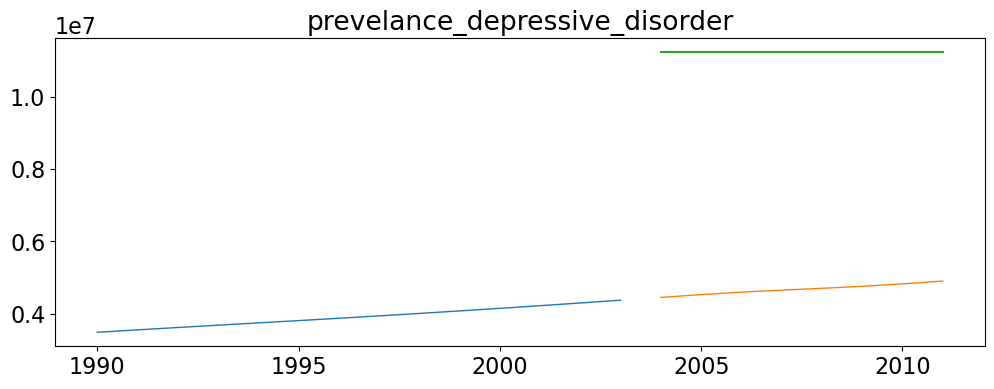

anxiety_disorders -- RMSE: 0


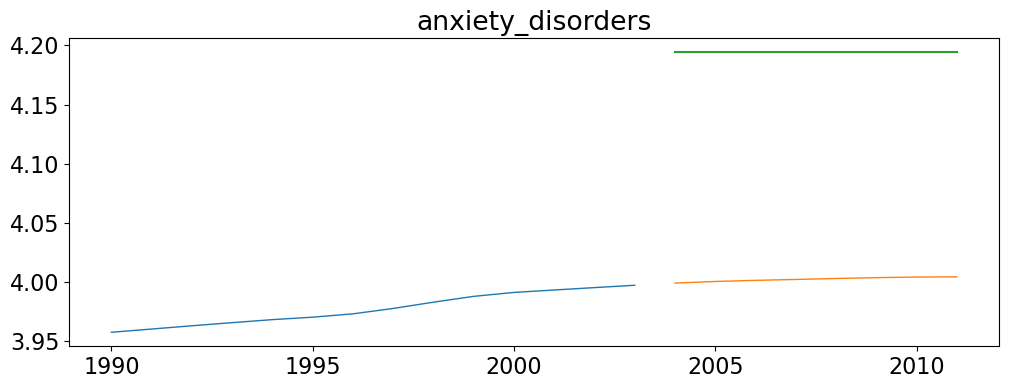

In [23]:
for col in train[X_cols].columns:
    me.plot_and_eval(yhat_df, target_var = col)

In [24]:
for col in train[X_cols].columns:
    d = me.append_eval_df(yhat_df, model_type = 'holts_optimized', target_var = col)
    eval_df = eval_df.append(d, ignore_index=True)

In [25]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,prevelance_depressive_disorder,334699.0
1,last_observed_value,anxiety_disorders,0.0
2,simple_average,prevelance_depressive_disorder,772934.0
3,simple_average,anxiety_disorders,0.0
4,moving_average,prevelance_depressive_disorder,334699.0
5,moving_average,anxiety_disorders,0.0
6,holts_optimized,prevelance_depressive_disorder,6551549.0
7,holts_optimized,anxiety_disorders,0.0


Lets use the moving_average model on the test.

In [26]:
period = 1 

rolling_depression = train['prevelance_depressive_disorder'].rolling(period).mean()
rolling_anxiety = train['anxiety_disorders'].rolling(period).mean()
rolling_anxiety = rolling_anxiety.tolist()[-1]
rolling_depression= rolling_depression.tolist()[-1]

In [27]:
yhat_df = pd.DataFrame(
    {
        'prevelance_depressive_disorder': [rolling_depression],
         'anxiety_disorders': [rolling_anxiety]},
                          index=test.index)
yhat_df

,prevelance_depressive_disorder,anxiety_disorders
year,,
2012,4.376706e+06,3.997061
2013,4.376706e+06,3.997061
2014,4.376706e+06,3.997061
2015,4.376706e+06,3.997061
2016,4.376706e+06,3.997061
2017,4.376706e+06,3.997061


In [28]:
def final_plot(yhatdf, target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [29]:
rmse_depression = sqrt(mean_squared_error(test['prevelance_depressive_disorder'], 
                                       yhat_df['prevelance_depressive_disorder']))

rmse_anxiety = sqrt(mean_squared_error(test['anxiety_disorders'], 
                                       yhat_df['anxiety_disorders']))

In [30]:
print(f'The RMSE on the test dataset for depression is {rmse_depression} using the rolling average model.')
print(f'The RMSE on the test dataset for anxiety is {rmse_anxiety} using the rolling average model.')

The RMSE on the test dataset for depression is 815449.0035915383 using the rolling average model.
The RMSE on the test dataset for anxiety is 0.006412699862971066 using the rolling average model.


Takeaways:  My Time Series models did not do very well in predicting the prevalance of depressive disorders, and while it seems it did okay in predicting the global anxiety disorder percentage, the RMSE may be good on the surface on account of the numbers being pretty consistant and the number of observations being small.

### Linear Regression

In [31]:
train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test, columns_to_scale=train.columns)

In [32]:
X_train = train_scaled.drop(columns='prevelance_depressive_disorder')
X_validate = validate_scaled.drop(columns='prevelance_depressive_disorder')
X_test = test_scaled.drop(columns='prevelance_depressive_disorder')

y_train = train['prevelance_depressive_disorder']
y_validate = validate['prevelance_depressive_disorder']
y_test = test['prevelance_depressive_disorder']

In [33]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

**Establishing Baseline**

In [34]:
y_train['baseline_mean'] = y_train.prevelance_depressive_disorder.mean()
y_validate['baseline_mean'] = y_train.prevelance_depressive_disorder.mean()
y_train['baseline_median'] = y_train.prevelance_depressive_disorder.median()
y_validate['baseline_median'] = y_train.prevelance_depressive_disorder.median()

In [35]:
# RMSE of mean
rmse_train_mu = mean_squared_error(y_train.prevelance_depressive_disorder,
                                y_train.baseline_mean) ** .5

rmse_validate_mu = mean_squared_error(y_validate.prevelance_depressive_disorder, 
                                      y_validate.baseline_mean) ** (0.5)

print(f"""RMSE using Mean
Train/In-Sample: {round(rmse_train_mu, 2)} 
Validate/Out-of-Sample: {round(rmse_validate_mu, 2)}""")

RMSE using Mean
Train/In-Sample: 272216.57 
Validate/Out-of-Sample: 772933.79


In [36]:
# RMSE of median
rmse_train_med = mean_squared_error(y_train.prevelance_depressive_disorder,
                                y_train.baseline_median) ** .5

rmse_validate_med = mean_squared_error(y_validate.prevelance_depressive_disorder, 
                                      y_validate.baseline_median) ** (0.5)

print(f"""RMSE using Mean
Train/In-Sample: {round(rmse_train_med, 2)} 
Validate/Out-of-Sample: {round(rmse_validate_med, 2)}""")

RMSE using Mean
Train/In-Sample: 272402.07 
Validate/Out-of-Sample: 782816.84


In [37]:
# Let's house our metrics in a df to later compare

metric_df = pd.DataFrame(data=[
    {'model': 'mean_baseline',
     'RMSE_train': rmse_train_mu,
     'RMSE_validate': rmse_validate_mu,
     'R2_validate': explained_variance_score(y_validate.prevelance_depressive_disorder,
                                             y_validate.baseline_mean)
    }
]
)

**Linear Regression: Creating and Evaluating the Model**

In [38]:
# MAKE THE THING: create the model object
lm = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = lm.fit(X_train, y_train.prevelance_depressive_disorder)

#2. USE THE THING: make a prediction
y_train['depression_pred_lm'] = lm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.prevelance_depressive_disorder, y_train.depression_pred_lm)**.5

# predict validate
y_validate['depression_pred_lm'] = lm.predict(X_validate)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.prevelance_depressive_disorder, y_validate.depression_pred_lm)**.5

print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

metric_df = metric_df.append(
    {
        'model': 'OLS_Regressor',
        'RMSE_train': rmse_train,
        'RMSE_validate': rmse_validate,
        'R2_validate': explained_variance_score(y_validate.prevelance_depressive_disorder, 
                                                y_validate.depression_pred_lm)
    }, ignore_index=True

)

RMSE for OLS using LinearRegression
Training/In-Sample:  4.978128558256186e-10 
Validation/Out-of-Sample: 149642.9940651157
Difference:  149642.9940651152


**LassoLars: Creating and Evaluating the Model**

In [49]:
# MAKE THE THING: create the model object
lars = LassoLars(alpha=30)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.prevelance_depressive_disorder)

#2. USE THE THING: make a prediction
y_train['depression_pred_lars'] = lars.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.prevelance_depressive_disorder, y_train.depression_pred_lars) ** .5

#4. REPEAT STEPS 2-3

# predict validate
y_validate['depression_pred_lars'] = lars.predict(X_validate)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.prevelance_depressive_disorder, y_validate.depression_pred_lars) ** .5

print(f"""RMSE for Lasso + Lars
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

metric_df = metric_df.append(
    {
        'model': 'lasso_alpha',
        'RMSE_train': rmse_train,
        'RMSE_validate': rmse_validate,
        'R2_validate': explained_variance_score(y_validate.prevelance_depressive_disorder, 
                                                y_validate.depression_pred_lars)
    }, ignore_index=True

)

RMSE for Lasso + Lars
_____________________
Training/In-Sample: 888.7831287036691, 
Validation/Out-of-Sample:  3226.2401794865937
Difference:  2337.4570507829244


**TweedieRegressor (GLM:Generalized Linear Model): Creating and Evaluating the Model**

<AxesSubplot:>

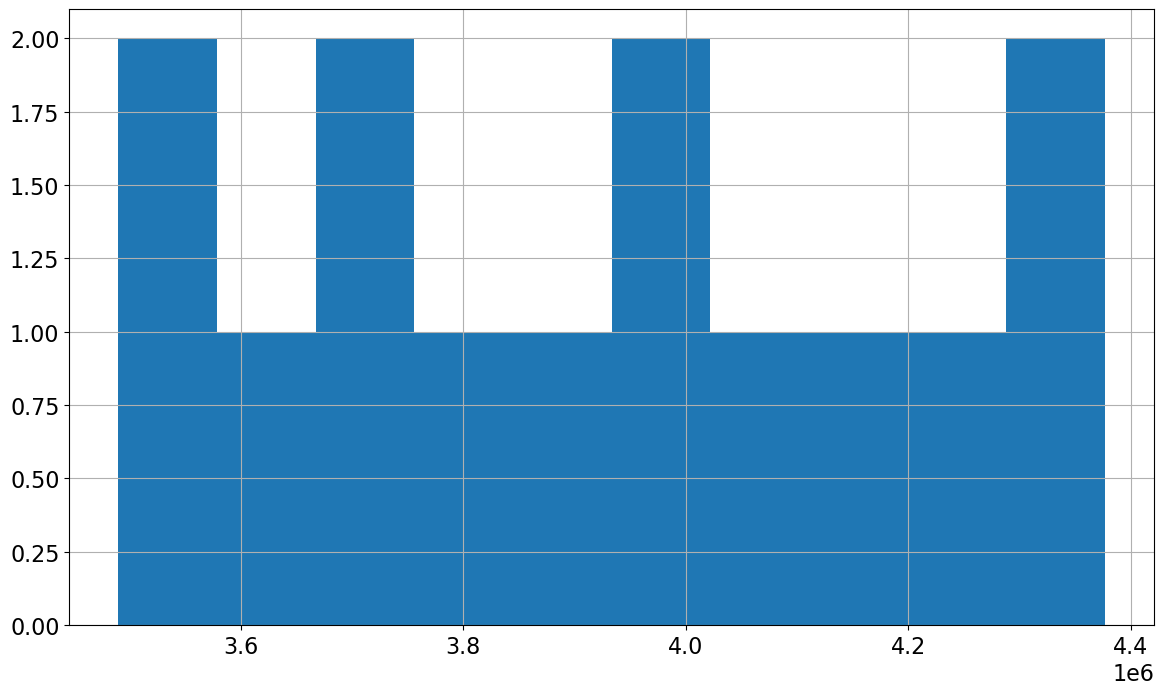

In [40]:
y_train.prevelance_depressive_disorder.hist()

In [41]:
# MAKE THE THING: create the model object
glm = TweedieRegressor(power=1, alpha=500_000)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
glm.fit(X_train, y_train.prevelance_depressive_disorder)

#2. USE THE THING: make a prediction
y_train['depression_pred_glm'] = glm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.prevelance_depressive_disorder, y_train.depression_pred_glm)**(1/2)

#4. REPEAT STEPS 2-3

# predict validate
y_validate['depression_pred_glm'] = glm.predict(X_validate)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.prevelance_depressive_disorder, y_validate.depression_pred_glm)**(1/2)

print(f"""RMSE for GLM using Tweedie, power=1 & alpha=0
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

#Append
metric_df = metric_df.append(
    {
        'model': 'glm_gamma',
        'RMSE_train': rmse_train,
        'RMSE_validate': rmse_validate,
        'R2_validate': explained_variance_score(y_validate.prevelance_depressive_disorder, 
                                                y_validate.depression_pred_glm)
    }, ignore_index=True

)

RMSE for GLM using Tweedie, power=1 & alpha=0
_____________________
Training/In-Sample: 32233.00809542184, 
Validation/Out-of-Sample:  59107.73145829464
Difference:  26874.723362872803


**Polynomial Regression: Creating and Evaluating the Model**

In [42]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.prevelance_depressive_disorder)

# predict train
y_train['depression_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.prevelance_depressive_disorder, y_train.depression_pred_lm2)**(1/2)

# predict validate
y_validate['depression_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.prevelance_depressive_disorder, y_validate.depression_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#Append
metric_df = metric_df.append(
    {
        'model': 'quadratic',
        'RMSE_train': rmse_train,
        'RMSE_validate': rmse_validate,
        'R2_validate': explained_variance_score(y_validate.prevelance_depressive_disorder, 
                                                y_validate.depression_pred_lm2)
    }, ignore_index=True

)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  5.280102691742041e-10 
Validation/Out-of-Sample:  160983.3554644224


In [43]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,2.722166e+05,772933.792573,0.000000
1,OLS_Regressor,4.978129e-10,149642.994065,0.608792
2,lasso_alpha,8.887831e+02,3226.240179,0.999485
3,glm_gamma,3.223301e+04,59107.731458,0.895602
4,quadratic,5.280103e-10,160983.355464,0.456246


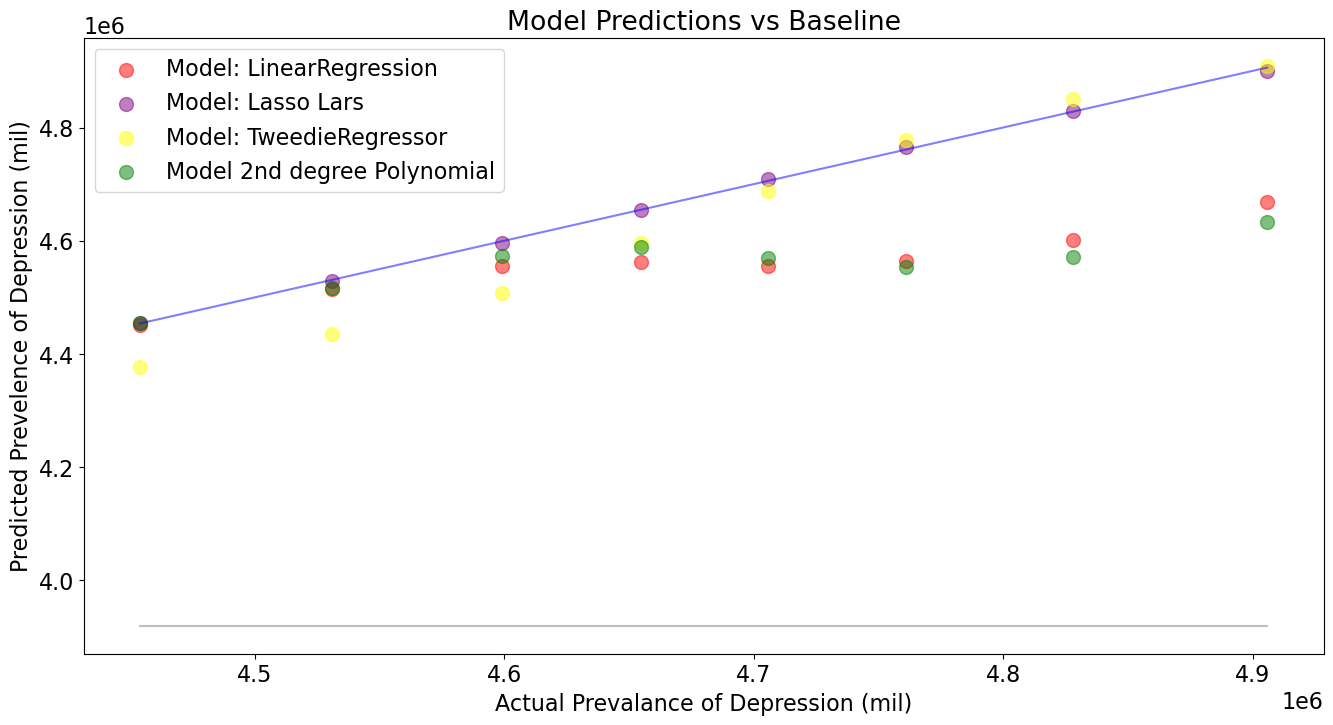

In [48]:
# Visualization of each model's validate performance compared to the baseline and to each other

plt.figure(figsize=(16,8))
#actual vs mean
plt.plot(y_validate.prevelance_depressive_disorder, y_validate.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (4_000_000, 4_000_000))

#actual vs. actual
plt.plot(y_validate.prevelance_depressive_disorder, y_validate.prevelance_depressive_disorder, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

#actual vs. LinearReg model
plt.scatter(y_validate.prevelance_depressive_disorder, y_validate.depression_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#actual vs. LassoLars model
plt.scatter(y_validate.prevelance_depressive_disorder, y_validate.depression_pred_lars, 
            alpha=.5, color="purple", s=100, label="Model: Lasso Lars")
#actual vs. Tweedie/GenLinModel
plt.scatter(y_validate.prevelance_depressive_disorder, y_validate.depression_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#actual vs. PolynomReg/Quadratic
plt.scatter(y_validate.prevelance_depressive_disorder, y_validate.depression_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Prevalance of Depression (mil)")
plt.ylabel("Predicted Prevelence of Depression (mil)")
plt.title("Model Predictions vs Baseline")
plt.show()

#### Testing

In [45]:
# predict on test
y_test['depression_pred_lars'] = lars.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.prevelance_depressive_disorder, y_test.depression_pred_lars)**(1/2)

print("RMSE for LassoLars Model using Linear Regression\nOut-of-Sample Performance: ", rmse_test)

RMSE for LassoLars Model using Linear Regression
Out-of-Sample Performance:  33160.761287652815


In [46]:
# Evaluating the GLM model against the baseline

((rmse_train_mu - rmse_test)/rmse_train_mu) * 100

87.81824270971035

**Conclusion:**  My time series models did not perform very well on a continuously increasing metric like global depression rates. After fine tuning the LassoLars model, I thought I may see some overfitting. The differences in RMSE scores for the train, validate, and test sets were a little turbulent, but the model still performed better than any of the other models on the test set compared to the validate and train sets. The model was able to perform 87.82% better than the mean baseline.